<a href="https://colab.research.google.com/github/vdavid033/Research-Paper-Summarization/blob/master/Abstractive_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research Paper Summarization

### Team:
Kevin Thomas <br>
Janani Arunachalam <br>

In [1]:
# tqdm version 4.36.1 is required


!pip install tqdm==4.36.1

In [2]:
# Mounting Drive


from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Importing Libaries


import numpy as np  
import pandas as pd 
import re           
import glob
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import keras
import warnings
import nltk
nltk.download('stopwords')
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Progress bar


from tqdm import tqdm
tqdm.pandas()

In [0]:
# Reading Pickle'd file which has data stored in a dataframe
# with headings: "text", "filenames", "highlights", "body"

# orig
# data = pd.read_pickle("/content/drive/My Drive/NLP Project/Project Final/papers.pkl")

data = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/papers.pkl")

## Text Preprocessing

In [9]:
# Preprocessing "body" text


from spacy.lang.en.stop_words import STOP_WORDS
 
def clean_body(text):
    newText = text.lower()
    newText = re.sub('[^\w\s\d\.]','',newText)
    newText = ' '.join(newText.split())
    tokens = [w for w in newText.split() if not w in STOP_WORDS]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_body = []
for t in data['body']:
    cleaned_body.append(clean_body(t))

cleaned_body[:5]

['deterministic approaches simultaneously solve different interrelated optimisation problems lead general class nonlinear complementarity problem ncp. differentiability convexity requirements problems sophisticated algorithms introduced literature. paper develops evolutionary algorithm solve ncps. proposed approach parallel search multiple populations representing different agents evolve simultaneously whilst contact other. context agent autonomously solves optimisation programme sharing decisions neighbouring agents affects actions. framework applied environmental aerospace application obtained results compared found literature. convergence scalability approach tested search algorithm performance analysed. results encourage application evolutionary based algorithm complementarity problems future work investigate development performance improvements. study class problems solutions interrelated optimisation problems simultaneously required. context agent solves optimisation problem seek

In [10]:
# Preprocessing "highlight" text


def clean_highlight(text):
  newText = text.lower()
  newText = re.sub('[^\w\s\d\.]','',newText)
  newText = ' '.join(newText.split())
  newText = '_START_ '+ newText + ' _END_'
  return newText

cleaned_highlight = []
for t in data['highlights']:
    cleaned_highlight.append(clean_highlight(t))

cleaned_highlight[:5]

['_START_ we develop an evolutionary approach to solve interrelated optimisation problems. multiple agents autonomously deal with their own problems and react to the others. test problems in water pollution and aerospace modelling demonstrate the algorithm. experiments on scalability and convergence of the algorithm show promising results. _END_',
 '_START_ the aggregated artificial neural network was used to investigate the simultaneous effects of printing parameters on the compressive strength and porosity of scaffolds. particle swarm optimization algorithm was implemented to obtain the optimum topology of the aann. pareto front optimization was used to determine the optimal setting parameters. the presented results and discussion can give informative information to practitioners who want to design a porous structure and need to know the impact of influential design parameters. _END_',
 '_START_ a stochastic global optimization framework for open pit mining complexes is proposed. the

In [0]:
# Storing preprocessed data in the dataframe


data['cleaned_highlights'] = cleaned_highlight
data['cleaned_body'] = cleaned_body

Retriving 5000 papers from the dataframe as more computational power is needed for the entire 8k data.

In [0]:
data = data[:5000]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 27 to 6950
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                5000 non-null   object
 1   filenames           5000 non-null   object
 2   highlights          5000 non-null   object
 3   body                5000 non-null   object
 4   cleaned_highlights  5000 non-null   object
 5   cleaned_body        5000 non-null   object
dtypes: object(6)
memory usage: 273.4+ KB


Visualizing the document length distribution for "body" and "highlights" to estimate optimal maximum length to create equal length vectors for words.

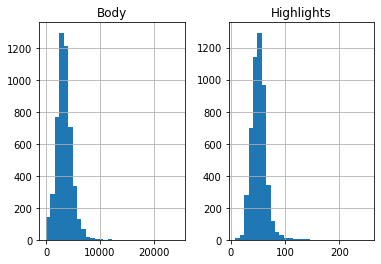

In [14]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

for i in data['cleaned_body']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_highlights']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Body':text_word_count, 'Highlights':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [0]:
max_len_body = 1000
max_len_highlight = 50

In [16]:
# Converting cleaned data into strings


data.cleaned_body = data.cleaned_body.progress_apply(lambda x: str(x))
data.cleaned_highlights = data.cleaned_highlights.progress_apply(lambda x: str(x))

100%|██████████| 5000/5000 [00:00<00:00, 591580.25it/s]


In [0]:
# Splitting data into training and test sets
# Test set is 20% of total data


from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data['cleaned_body'],data['cleaned_highlights'],test_size=0.2,random_state=0,shuffle=True) 

Tokenizer class from Keras is used to create equal length vectors for each word.

In [0]:
# Tokenizing "body"
x_tok = Tokenizer()
x_tok.fit_on_texts(list(x_train))

# Converting text to number sequences
x_train = x_tok.texts_to_sequences(x_train) 
x_test = x_tok.texts_to_sequences(x_test)

# Padding zero upto maximum length
x_train = pad_sequences(x_train,  maxlen=max_len_body, padding='post') 
x_test = pad_sequences(x_test, maxlen=max_len_body, padding='post')

# Total number of words
x_vocab_size = len(x_tok.word_index) +1

In [0]:
# Tokenizing "highlights"
y_tok = Tokenizer()
y_tok.fit_on_texts(list(y_train))

# Converting text to number sequences
y_train = y_tok.texts_to_sequences(y_train) 
y_test = y_tok.texts_to_sequences(y_test)

# Padding zero upto maximum length
y_train = pad_sequences(y_train,  maxlen=max_len_highlight, padding='post') 
y_test = pad_sequences(y_test, maxlen=max_len_highlight, padding='post')

# Word count
y_vocab_size = len(y_tok.word_index) +1

## Model Definition

Attention Layer required to remember context information. As there is no Keras implementation for Attention Layer we have found a third-party resource to aid in our model. Reference: https://github.com/thushv89/attention_keras/blob/master/layers/attention.py

In [0]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

Model Creation

In [22]:
#from keras import backend as K 
from tensorflow.python.keras import backend as K

K.clear_session() 
latent_dim = 50 


# Encoder 
encoder_inputs = Input(shape=(max_len_body,)) 
enc_emb = Embedding(x_vocab_size, latent_dim,trainable=True)(encoder_inputs) 

# 1st LSTM Layer
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

# 2nd LSTM Layer
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

# 3rd LSTM Layer
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_vocab_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Model Definition
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 50)     12730400    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1000, 50), ( 20200       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

RMSProp was found to be the best optimizer for text summarization and sparse categorical crossentropy was found to be the best loss functiom from this reference: https://hackernoon.com/text-summarization-using-keras-models-366b002408d9

Sparse categorical cross entropy is used as the loss function because it automatically converts an integer sequence to a one-hot encoded vector, hence requiring less memory.

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Validation loss was monitored to make sure that the model does not get worse. The model training is stopped if validation loss for the current iteration is higher than the validation loss for the previous iteration.

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

## Model Training

In [26]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:], epochs=30, callbacks=[es], batch_size=128, validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/30


TypeError: ignored

In [0]:
model.save('/content/drive/My Drive/NLP Project/Project Final/model.h5')

In [0]:
# Visualizing training ans test loss functions


from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

Building dictionary for target and source words, to convert the index to word.

In [0]:
reverse_target_word_index=y_tok.index_word 
reverse_source_word_index=x_tok.index_word 
target_word_index=y_tok.word_index

## Inference Stage

In [0]:
# Encoder Inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder Inference
# Below tensors hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_body,latent_dim))

# Getting decoder sequence embeddings
dec_emb2= dec_emb_layer(decoder_inputs)

# Predicting the next word in the sequence
# Setting the initial states to the previous time step states
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention Inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Dense softmax layer to calculate probability distribution over target vocab
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final Decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [0]:
# Function to implement inference



def decode_sequence(input_seq):
    # Encoding input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generating empty target sequence of length 1
    target_seq = np.zeros((1,1))

    # Taking the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        try:
            sampled_token = reverse_target_word_index[sampled_token_index]
        except:
            sampled_token = reverse_target_word_index[np.random.randint(1, len(reverse_target_word_index))]
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_highlight-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Function to convert interger sequence to word sequence for highlights.

In [0]:
def seq2highlights(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

## Displaying Results:

In [0]:
reference = []
hypothesis = []
for i in range(10):
  print("Highlights:")
  print(seq2summary(y_test[i]))
  reference.append(seq2highlights(y_test[i]))
  print("\n")
  print("Predicted summary:")
  print(decode_sequence(x_test[i].reshape(1,max_len_body)))
  hypothesis.append(decode_sequence(x_test[i].reshape(1,max_len_body)))
  print("\n")
  print("\n")

In [0]:
! pip install rouge

## Calculating Rouge Scores

In [0]:
from rouge import Rouge

In [0]:
score = Rouge()

In [0]:
score.get_scores(hypothesis, reference, avg = True)

<br>
<br>

ROUGH

In [0]:
# Reading papers, cleaning, creating & pickling dataframe


def read_paper(path):
  """
  Reads research papers and store them in a string
  """
  f = open(path, 'r', encoding="utf-8")
  text = str(f.read())
  f.close()
  return text


def create_dataframe(NO_INPUT_PAPERS):
  """
  Takes number of papers to read and stores data in a dataframe
  """
  temp_papers = []
  filenames = []
  for filename in tqdm(glob.glob("/content/drive/My Drive/NLP Project/Project Final/Parsed_Papers/*.txt")[:NO_INPUT_PAPERS]):
      temp_papers.append(read_paper(filename))
      filenames.append(filename)
  return pd.DataFrame(list(zip(temp_papers, filenames)), columns =['text', 'filenames'])


def clean_text(text):
  """
  Removes unwanted characters, accounting for unicode characters
  """
  text = re.sub("@&#", " ", text)
  text = re.sub("\n", " ", text)
  text = (text.encode('ascii', 'ignore')).decode("utf-8")
  return text


data = create_dataframe(NO_INPUT_PAPERS = 10000)

data['highlights'] = data['text'].progress_apply(lambda x: re.findall(r'HIGHLIGHTS(.*?)KEYPHRASES', x,  flags = re.I)[0])
data = data[data.highlights != '    ']

data['body'] = data['text'].progress_apply(lambda x: re.findall(r'.*(?:abstract )(.*?)$', x,  flags = re.I)[0])

data.to_pickle("./papers.pkl")

In [0]:
data = pd.read_pickle("/content/drive/My Drive/NLP Project/Project Final/data.pkl")
data.head()

In [0]:
# Function to find filename which don't have "highlights" in it


def file_name(NO_INPUT_PAPERS):
  temp_papers = []
  for filename in glob.glob("/content/drive/My Drive/NLP Project/Project Final/Parsed_Papers/*.txt")[:NO_INPUT_PAPERS]:
    text = read_paper(filename)
    text = re.sub("@&#", " ", text)
    text = re.sub("\n", " ", text)
    text = (text.encode('ascii', 'ignore')).decode("utf-8")
    highlights = re.findall(r'HIGHLIGHTS(.*?)KEYPHRASES', text,  flags = re.I)
    if highlights == []:
      print(filename)